In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

from matplotlib import pyplot as plt
from prettytable import PrettyTable

Using TensorFlow backend.


In [0]:
def plot_loss(x, vy, ty, xlabel='Epoch', ylabel='Binary Crossentropy Loss'):
    _, = plt.plot(x, vy, 'b', label="Validation Loss")
    _, = plt.plot(x, ty, 'r', label="Train Loss")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.legend()
    plt.grid()
    plt.show()

In [0]:
pt = PrettyTable()
pt.field_names = ['RNN Architecture', 'Mean Train Accuracy', 'Mean Validation Accuracy', 'Test Accuracy']

In [1]:
# --> Step to access files in gdrive.
from google.colab import drive
drive.mount('/content/gdrive')

In [5]:
%%time
# --> The csv files contain pre-processed data of the Reviews - select unique rows, punctuations & html tags removed,
# a featurizations added and Stemming performed on the data. Sample data is displayed below.
data_train = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/sample_data_train.csv')
data_test = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/sample_data_test.csv')

print(data_train.iloc[0]['CleanedText'])

rememb see show air televis year ago child sister later bought day thirti someth use seri book song student teach preschool turn whole school purchas along book children tradit live whole  great spend
CPU times: user 322 ms, sys: 59.5 ms, total: 381 ms
Wall time: 1.77 s


In [0]:
def load_data(num_words=5000):
    '''
    This Function basically prepares the data to be loaded and processed similar to IMDB data in datasets.
    1. A Vocabulary is created with all the words and it's Frequencies.
    2. Top 'num_words' are selected and another dictionary 'word_idx' is created to store the ranks of the corresponding words.
    3. Finally, train and test data (x's & y's) are returned to the caller.
    '''
    vocab = Counter()
    word_idx = dict()
    cnt = 1
    max_sent_len = 0
    for review in data_train['CleanedText']:
        if len(review.split()) > max_sent_len:
            max_sent_len = len(review.split())
        for word in review.split():
            vocab[word] += 1

    for x,y in vocab.most_common(num_words):
        word_idx[x] = cnt
        cnt += 1
        
    print(f'Most Common Words :-\n{vocab.most_common(10)}')
    print(f'Word Ranks :-\n{word_idx}')
    print(f'Max Review Length - {max_sent_len}')
    
    def transform_data(data):
        data_idx = []
        for review in data['CleanedText']:
            temp_idx = []
            for word in review.split():
                if 0 < word_idx.get(word, 0) <= num_words:
                    temp_idx.append(word_idx[word])
            data_idx.append(temp_idx)

        return data_idx
        
    X_train = transform_data(data_train)
    X_test = transform_data(data_test)
    y_train = data_train['Score']
    y_test = data_test['Score']
    
    return (X_train, y_train), (X_test, y_test)

In [7]:
%%time
num_words = 5000
(X_train, y_train), (X_test, y_test) = load_data(num_words=num_words)

Most Common Words :-
[('not', 7305), ('great', 6203), ('like', 6190), ('tast', 5998), ('good', 5981), ('tea', 5409), ('love', 4992), ('flavor', 4755), ('one', 4217), ('product', 4130)]
Word Ranks :-
{'not': 1, 'great': 2, 'like': 3, 'tast': 4, 'good': 5, 'tea': 6, 'love': 7, 'flavor': 8, 'one': 9, 'product': 10, 'use': 11, 'tri': 12, 'best': 13, 'make': 14, 'get': 15, 'food': 16, 'eat': 17, 'coffe': 18, 'buy': 19, 'would': 20, 'realli': 21, 'time': 22, 'also': 23, 'much': 24, 'find': 25, 'order': 26, 'amazon': 27, 'littl': 28, 'even': 29, 'bag': 30, 'well': 31, 'dog': 32, 'better': 33, 'delici': 34, 'chocol': 35, 'price': 36, 'store': 37, 'mix': 38, 'sugar': 39, 'box': 40, 'drink': 41, 'recommend': 42, 'day': 43, 'sweet': 44, 'treat': 45, 'high': 46, 'year': 47, 'snack': 48, '[]': 49, 'cat': 50, 'favorit': 51, 'want': 52, 'found': 53, 'look': 54, 'first': 55, 'enjoy': 56, 'wonder': 57, 'give': 58, 'cup': 59, 'healthi': 60, 'nice': 61, 'think': 62, 'brand': 63, 'packag': 64, 'cooki': 65

In [8]:
print(X_train[0])
print(data_train.iloc[0]['CleanedText'])

[478, 158, 692, 1097, 4413, 47, 326, 813, 1184, 547, 87, 43, 3878, 126, 11, 2524, 853, 4414, 1827, 3116, 375, 114, 839, 93, 531, 853, 649, 532, 246, 114, 2, 826]
rememb see show air televis year ago child sister later bought day thirti someth use seri book song student teach preschool turn whole school purchas along book children tradit live whole  great spend


In [9]:
# truncate and/or pad input sequences
max_review_length = 824
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape, X_test.shape)

(14000, 824) (6000, 824)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 824, 32)           160000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 2)                 280       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 160,283
Trainable params: 160,283
Non-trainable params: 0
_________________________________________________________________
None
Train on 9800 samples, validate on 4200 samples
Epoch 1/5
9800/9800 [==============================] - 367s 37ms/step - loss: 1.9517 - acc: 0.1169 - val_loss: 0.8004 - val_acc: 0.3095
Epoch 2/5
9800/9800 [==============================] - 366s 37ms/step - loss: 0.4209 - acc: 0.8362 - val_loss: 0.3753 - val_acc: 0.9007
Epoch 3/5
9800/9800 [==============================] - 367s 37ms/step - los

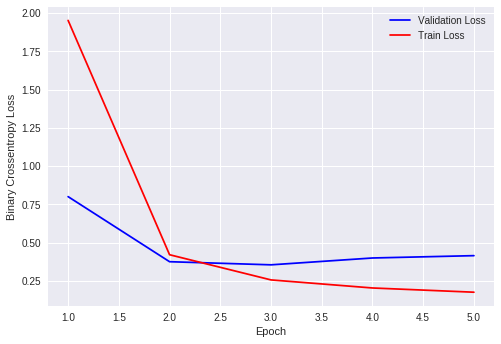

CPU times: user 42min 18s, sys: 5min 55s, total: 48min 14s
Wall time: 32min 58s


In [0]:
%%time
# create the model
def get_LSTM(embedding_vector_length = 32):
    model = Sequential()
    model.add(Embedding(num_words, embedding_vector_length, input_length=max_review_length))

    model.add(LSTM(2))

    model.add(Dense(1, activation='relu', kernel_initializer='he_normal'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model


model = get_LSTM()
epochs = 5
history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_split=0.3)

# Final evaluation of the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x = list(range(1, epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plot_loss(x, vy, ty)

pt.add_row(['1-layered LSTM', sum(history.history['acc'])/len(history.history['acc']), \
            sum(history.history['val_acc'])/len(history.history['val_acc']), score[1]])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 824, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 2)                 280       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 160,283
Trainable params: 160,283
Non-trainable params: 0
_________________________________________________________________
None
Train on 9800 samples, validate on 4200 samples
Epoch 1/10
9800/9800 [==============================] - 478s 49ms/step - loss: 2.0914 - acc: 0.1095 - val_loss: 0.9852 - val_acc: 0.1086
Epoch 2/10
9800/9800 [==============================] - 470s 48ms/step - loss: 0.6777 - acc: 0.5869 - val_loss: 0.4391 - val_acc: 0.8950
Epoch 3/10
9800/9800 [==============================] - 472s 48ms/step - 

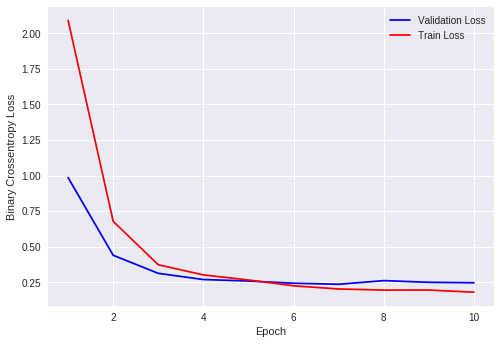

CPU times: user 1h 43min 58s, sys: 13min 29s, total: 1h 57min 27s
Wall time: 1h 20min 47s


In [0]:
%%time
# create the model
def get_LSTM(embedding_vector_length = 32):
    model = Sequential()
    model.add(Embedding(num_words, embedding_vector_length, input_length=max_review_length))

    model.add(LSTM(2, dropout=0.25, recurrent_dropout=0.25))

    model.add(Dense(1, activation='relu', kernel_initializer='he_normal'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model


model = get_LSTM()
epochs = 10
history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_split=0.3)

# Final evaluation of the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x = list(range(1, epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plot_loss(x, vy, ty)

pt.add_row(['1-layered LSTM+Dropouts', sum(history.history['acc'])/len(history.history['acc']), \
            sum(history.history['val_acc'])/len(history.history['val_acc']), score[1]])

In [0]:
print(pt)

+-------------------------+---------------------+--------------------------+--------------------+
|     RNN Architecture    | Mean Train Accuracy | Mean Validation Accuracy |   Test Accuracy    |
+-------------------------+---------------------+--------------------------+--------------------+
| 1-layered LSTM+Dropouts |  0.8109999999999999 |    0.8280952381534237    | 0.9023333333333333 |
+-------------------------+---------------------+--------------------------+--------------------+


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 824, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 824, 10)           1720      
_________________________________________________________________
lstm_2 (LSTM)                (None, 2)                 104       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 161,827
Trainable params: 161,827
Non-trainable params: 0
_________________________________________________________________
None
Train on 9800 samples, validate on 4200 samples
Epoch 1/5
9800/9800 [==============================] - 949s 97ms/step - loss: 1.7820 - acc: 0.1463 - val_loss: 0.6789 - val_acc: 0.8914
Epoch 2/5
9800/9800 [==============================] - 956s 98ms/step - loss: 0

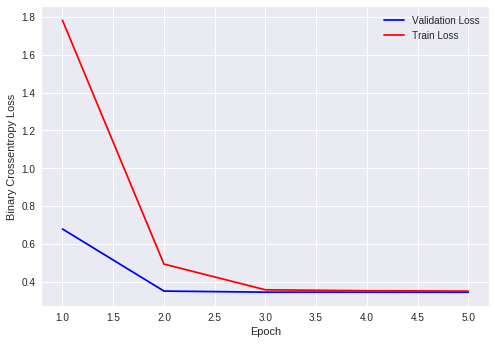

+-------------------------+---------------------+--------------------------+---------------+
|     RNN Architecture    | Mean Train Accuracy | Mean Validation Accuracy | Test Accuracy |
+-------------------------+---------------------+--------------------------+---------------+
| 2-layered LSTM+Dropouts |  0.7295102040816326 |    0.8914285712015062    |     0.875     |
+-------------------------+---------------------+--------------------------+---------------+
CPU times: user 1h 51min 12s, sys: 13min 17s, total: 2h 4min 29s
Wall time: 1h 24min 56s


In [10]:
%%time
# create the model
def get_LSTM(embedding_vector_length = 32):
    model = Sequential()
    model.add(Embedding(num_words, embedding_vector_length, input_length=max_review_length))

    model.add(LSTM(10, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
    model.add(LSTM(2, dropout=0.25, recurrent_dropout=0.25))

    model.add(Dense(1, activation='relu', kernel_initializer='he_normal'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    
    return model


model = get_LSTM()
epochs = 5
history = model.fit(X_train, y_train, epochs=epochs, batch_size=64, validation_split=0.3)

# Final evaluation of the model
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x = list(range(1, epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plot_loss(x, vy, ty)

pt.add_row(['2-layered LSTM+Dropouts', sum(history.history['acc'])/len(history.history['acc']), \
            sum(history.history['val_acc'])/len(history.history['val_acc']), score[1]])

print(pt)

# Conclusion :
- A simple Input with Frequency of words is providing good Accuracy on Results.
- 1-layered 2-LSTM cell RNN Architecture is performing much better than it's 2-layered counterpart.
- Dropouts are helping in decreasing the Overfitting problem in the NN.